<a href="https://colab.research.google.com/github/kenanmorani/Audio_Signal_Processing_For_Music_Applications_idu/blob/main/Autio_Properties_of_three_wave_sounds/Windowing_Formants_Converting_to_midi_chromagram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Installing and Imprting required Libraries

import numpy as np
from IPython.display import Audio
from scipy.io import wavfile
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
import matplotlib.pyplot as plt
%matplotlib inline
import IPython
from IPython.display import Image
from IPython.core.display import HTML 
import warnings
warnings.filterwarnings('ignore')

!pip install spectrum
!pip install pysoundfile
!pip install librosa==0.8.0
import os, sys,shutil
from spectrum.window import create_window
from spectrum.linear_prediction import poly2lsf, lsf2poly
import librosa, librosa.display
from scipy.signal import lfilter, freqz
import soundfile as sf
import urllib.request
from scipy.signal import get_window, tukey

import importlib.util
if importlib.util.find_spec('essentia') is None:
  !pip install essentia
import essentia.standard as ess

     |████████████████████████████████| 235kB 16.7MB/s 
  Created wheel for spectrum: filename=spectrum-0.8.0-cp37-cp37m-linux_x86_64.whl size=234767 sha256=9c98582215f2472c50948372be6cc51d291e1e00424abf425210839c182114b6
  Stored in directory: /root/.cache/pip/wheels/62/de/fd/94dc5ad0a7d93803f4cb4a26744d21e91ac4bf0a63004d2b14
Successfully built spectrum
     |████████████████████████████████| 12.0MB 11.8MB/s 


# Use of sms tools

In [2]:
#CLeaning the clone 
!git clone https://github.com/MTG/sms-tools.git

sys.path.append('sms-tools/software/models/')
from utilFunctions import wavread, wavwrite

Cloning into 'sms-tools'...
remote: Enumerating objects: 5526, done.
remote: Total 5526 (delta 0), reused 0 (delta 0), pack-reused 5526
Receiving objects: 100% (5526/5526), 260.64 MiB | 35.92 MiB/s, done.
Resolving deltas: 100% (3302/3302), done.


# Reading Audio Files (All Audio files have the same frequency 44100Hz)

In [3]:
fs, x3 = wavread('/content/Kenan says a.wav')
plt.plot(x3)
IPython.display.Audio(x3, rate=fs)

ValueError: ignored

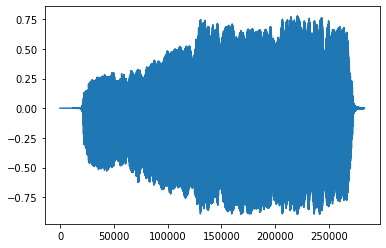

In [ ]:
fs, x1 = wavread('/content/kenan_sing_a.wav')
plt.plot(x1)
IPython.display.Audio(x1, rate=fs)

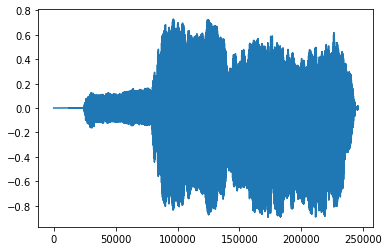

In [ ]:
fs, x2 = wavread('/content/kenan_sing_e.wav')
plt.plot(x2)
IPython.display.Audio(x2, rate=fs)

# Performing Windowing on kenan_sing_o

In [ ]:
speech_sig=x3 # Allowing speech_sig to take the value of the sound 'o'

# parameters
windowSize = 0.03*fs # The window length is 30 milliseconds
hopSize = 0.015*fs # The Hop/Shift size is 15 milliseconds
NRG_threshold_ratio = 0.05 #threshold expressed as ratio with respect to the maximum value (5%)
#Let's put in a container to be able to use as a single argument in function calls
params = {"fs":fs, "windowSize":windowSize, "hopSize":hopSize, "NRG_threshold_ratio": NRG_threshold_ratio}
#Function definition
def split_file(filename, params):
    '''Function to define split boundaries based on a fixed energy threshold
    '''
    x = ess.MonoLoader(filename = x3, sampleRate = fs)()
    NRG = [];
    #Main windowing and feature extraction loop
    for frame in ess.FrameGenerator(x, frameSize = windowSize, hopSize = hopSize, startFromZero = True):
        NRG.append(ess.Energy()(frame))
    NRG = np.array(NRG)
    NRG = NRG / np.max(NRG)
    
    #Applying energy threshold to decide wave split boundaries
    split_decision_func = np.zeros_like(NRG)
    split_decision_func[NRG > NRG_threshold_ratio] = 1
    #Setting segment boundaries
    #Inserting a zero at the beginning since we will decide the transitions using a diff function
    split_decision_func = np.insert(split_decision_func, 0, 0)
    diff_split_decision = np.diff(split_decision_func)
    #Start indexes: transition from 0 to 1
    start_indexes = np.nonzero(diff_split_decision > 0)[0] * hopSize
    #Stop indexes: transition from 1 to 0
    stop_indexes = np.nonzero(diff_split_decision < 0)[0] * hopSize
    return (x, NRG, split_decision_func, start_indexes, stop_indexes) 

# Producing Formant Space via Formant Values of Frames on kenen_sing_o. 



Number of polynomial coeffecients was set to 40 and Number of formants was set to 10.

r =  0.9941961 , freq =  429.58746 Hz
r =  0.9879279 , freq =  847.7788 Hz
r =  0.9856693 , freq =  4310.548 Hz
r =  0.9841639 , freq =  7284.8784 Hz
r =  0.97643685 , freq =  9020.924 Hz
r =  0.9725178 , freq =  2711.8105 Hz
r =  0.9672646 , freq =  22050.0 Hz
r =  0.95805717 , freq =  5871.8467 Hz
r =  0.942584 , freq =  10399.33 Hz
r =  0.9398565 , freq =  20838.873 Hz
Spectrum plots shifted and scaled for better viewing of the seperate components


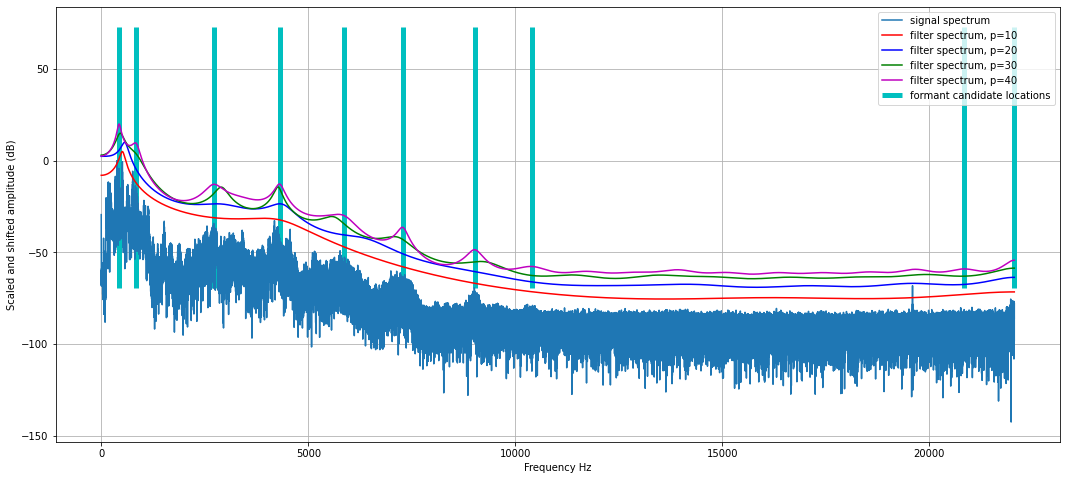

In [ ]:
windowed_sig = x3

def lpc_spectrum(speech_sig, num_coefs, num_freq_point):
  a = librosa.lpc(speech_sig, num_coefs)
  w, h = freqz(1, a, num_freq_points)
  return w, 20 * np.log10(np.abs(h))

def estimate_formants_lpc(speech_sig, fs, num_coefs=40, num_formants=10):
  a = librosa.lpc(speech_sig, num_coefs)
  roots = np.roots(a)
  roots_r = np.abs(roots)
  roots_theta = np.angle(roots)
  #drop roots at negative frequencies
  positive_freq_indexes = roots_theta > 0
  roots_r = roots_r[positive_freq_indexes]
  roots_theta = roots_theta[positive_freq_indexes]
  #sort roots with respect to their norm
  sort_indexes = np.flip(np.argsort(roots_r))
  roots_r = roots_r[sort_indexes]
  roots_theta = roots_theta[sort_indexes]

  return roots_r[:num_formants], roots_theta[:num_formants] * fs / (2 * np.pi)

num_formants = 10
roots_r, formant_candidate_freqs = estimate_formants_lpc(windowed_sig, fs, 40, num_formants)
for root_r, formant_freq in zip(roots_r, formant_candidate_freqs):
  print('r = ', root_r, ', freq = ', formant_freq, 'Hz')

fft_n = pow(2,int(np.log2(windowed_sig.size) + 1))
amp_spec = 20 * np.log10(np.abs(np.fft.fft(windowed_sig,n=fft_n)[:fft_n//2]))

print("Spectrum plots shifted and scaled for better viewing of the seperate components")
plt.figure(figsize=(18,8))
num_freq_points = amp_spec.size
w, filter_10_spec = lpc_spectrum(windowed_sig, 10, num_freq_points)
freq_axis = w * fs / (2*np.pi)
plt.plot(freq_axis, amp_spec-np.max(amp_spec), label='signal spectrum');
plt.plot(freq_axis, filter_10_spec - np.max(filter_10_spec) + 5, 'r', label='filter spectrum, p=10');
w, filter_20_spec = lpc_spectrum(windowed_sig, 20, num_freq_points)
plt.plot(freq_axis, filter_20_spec - np.max(filter_20_spec) + 10, 'b', label='filter spectrum, p=20');
w, filter_30_spec = lpc_spectrum(windowed_sig, 30, num_freq_points)
plt.plot(freq_axis, filter_30_spec - np.max(filter_30_spec) + 15, 'g', label='filter spectrum, p=30');
w, filter_40_spec = lpc_spectrum(windowed_sig, 40, num_freq_points)
plt.plot(freq_axis, filter_40_spec - np.max(filter_40_spec) + 20, 'm', label='filter spectrum, p=40');
plt.vlines(formant_candidate_freqs,np.min(amp_spec), np.max(amp_spec), 'c', linewidth = 5, label = 'formant candidate locations')
plt.legend();
plt.xlabel("Frequency Hz");
plt.ylabel("Scaled and shifted amplitude (dB)");
plt.grid();

# Crepe Function, Installing and Implementing

In [ ]:
!pip install crepe

     |████████████████████████████████| 368kB 5.9MB/s 
  Created wheel for crepe: filename=crepe-0.0.11-cp36-none-any.whl size=134848478 sha256=b5a09b8d99196b2cde7281fa0e03e65af0b3ab3963474fd6433b934382f3b246
  Stored in directory: /root/.cache/pip/wheels/7f/68/d0/502d27bfe590bfa51c6fe95cf9e4482fed18c22c480a8d7c77
Successfully built crepe


In [ ]:
import crepe 
import copy

In [ ]:
# Performing Crepe on kenan_sing_o
time, frequency, confidence, activation = crepe.predict(speech_sig, sr = fs, viterbi=True)
periods = 1 / frequency #periods in seconds

18/18 [==============================] - 28s 2s/step


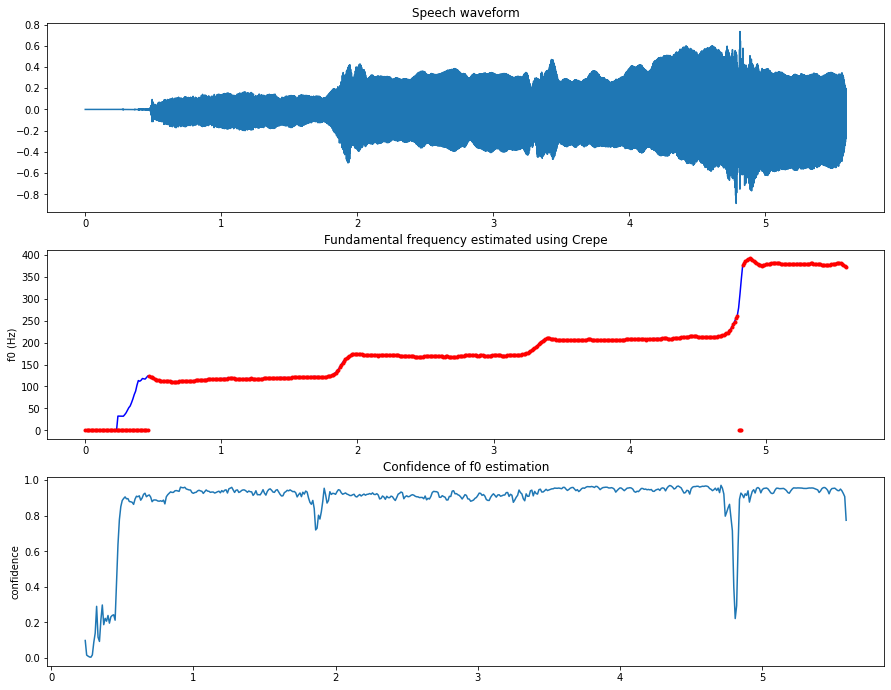

In [ ]:
# Plotting the fundemantal frequency estimation using crepe along with confedence of the estimation for kenan_sing_o 
# When confedence is less than 0.5, it is equalized to zero
fig = plt.figure(figsize=(15,16))
t_xax = np.arange(0,speech_sig.size/fs,1/fs)
plt.subplot(4,1,1)
plt.plot(t_xax, speech_sig)
plt.title('Speech waveform')
plt.subplot(4,1,2)
plt.plot(time, frequency,'b', label = 'crepe - all f0')
frequency_filtered = copy.deepcopy(frequency)
frequency_filtered[confidence < 0.5] = 0
plt.plot(time, frequency_filtered,'r.', label = 'crepe - high confidence f0')
plt.title('Fundamental frequency estimated using Crepe')
plt.ylabel('f0 (Hz)')
plt.subplot(4,1,3)
plt.plot(time, confidence)
plt.title('Confidence of f0 estimation')
plt.ylabel('confidence');

# Converting Fundemantal Frequencies to MIDI Numbers for kenan_sing_o

MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  32.41612787110046  Hz =  23
MIDI# of  32.405695145466304  Hz =  23
MIDI# of  32.15759665386904  Hz =  23
MIDI# of  32.21969282288693  Hz =  23
MIDI# of  32.16669268694083  Hz =  23
MIDI# of  35.67163742928615  Hz =  25
MIDI# of  39.87341228949034  Hz =  27
MIDI# of  45.99977107694913  Hz =  29
MIDI# of  51.59893475860257  Hz =  31
MIDI# of  55.441074330445076  Hz =  33
MIDI# of  63.0262314485607  Hz =  35
MIDI# of  71.62683874266855  

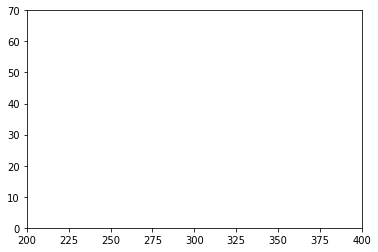

In [ ]:
def hz_to_midi(frequency_hz):
  if frequency_hz <= 0:
    return 0
  else:
     return 69 + np.log2(frequency_hz/440) * 12

frequencies = frequency
for freq_hz in frequencies:
  print('MIDI# of ',freq_hz, ' Hz = ', int(hz_to_midi(freq_hz)))

plt.xlim(200, 400)
plt.ylim(0,70)
plt.plot(freq_hz, int(hz_to_midi(freq_hz)))

# Plotting Chromagram for kenan_sing_o

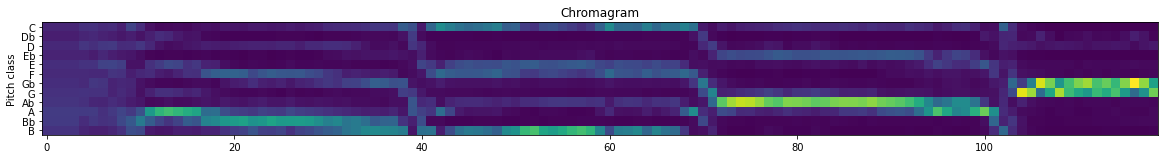

In [ ]:
def log_magnitude_spectrum(speech_sig, fftN):

  X = np.fft.fft(speech_sig, fftN)#computing fft
  absX = np.abs(X[:int(fftN / 2)])#taking first half of the spectrum and its magnitude
  absX[absX < np.finfo(float).eps] = np.finfo(float).eps#getting rid of zeros before the next step
  mX = 20 * np.log10(absX)
  return mX

def plot_chroma(speech_sig, windowFunction, windowSize, hopSize, fftN, min_freq, max_freq, fs):
  
  min_freq_bin = round(min_freq * fftN / fs)
  max_freq_bin = round(max_freq * fftN / fs)

  #Create the window function
  w = get_window(windowFunction, windowSize)

  #Required parameters for windowing
  startIndexes = np.arange(0, speech_sig.size - windowSize, hopSize, dtype = int)
  numWindows = startIndexes.size

  #Write the code to compute spectrogram (mX) in the form of a matrix
  # Performing windowing and using the logMagnitudeSpectrum function to compute the spectrum for each frame
  chroma = []
  for k in range(numWindows):
      startInd = startIndexes[k]
      x_win = speech_sig[startInd:startInd + windowSize] * w
      linear_spec = np.power(10, log_magnitude_spectrum(x_win, fftN) /20 )#better view with linear amplitude values
      bandEnergies = np.zeros((12,))
      for freqBin in np.arange(min_freq_bin,max_freq_bin):
          #Your code starts here
          # Write the code that maps freqBin to an integer midiNumber and adds
          # the amplitude of the spectrum at that bin at the 
          # corresponding component of 'bandEnergies' array
          freqBinHz = freqBin * fs / fftN
          binMidi = int(np.round(hz_to_midi(freqBinHz)))
          bandEnergies[np.mod(binMidi,12)] += linear_spec[freqBin]
          #Your code ends here
      bandEnergies = bandEnergies / np.sum(bandEnergies)
      chroma.append(bandEnergies)
  chroma = np.array(chroma) 

  pitchClasses = ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab','A', 'Bb', 'B']

  fig = plt.figure(figsize = (20, 8))
  plt.imshow(chroma.transpose())
  #ax.tick_params(axis = 'x',which = 'both',top = 'off',bottom = 'off',labelbottom = 'off') 
  plt.title('Chromagram')
  plt.yticks(np.arange(12), pitchClasses)
  plt.ylabel('Pitch class')
  return chroma

  #Initialize parameters
windowSize = 4096
hopSize = 2048
fftN = 4096
min_freq = 100
max_freq = 4000


plot_chroma(speech_sig, 'hann', windowSize, hopSize, fftN, min_freq, max_freq, fs);


# Comments on fundemantal frequencies, midi Numbers, and Chromogram results for kenan_sing_o

With increasing pitch of chromatic scale, the chroma values cycliclly rip around the virtical chroma axis.
The intensity of the sound is relatively low (blue colored in chromagram) with increasing of intensity over the peiod of the sound (seen in green). That also can be noticed through MIDI increasing values of integers and increasing of fundemantal frequencies.

# Implementing Cepstrum based fundemantal frequency detector

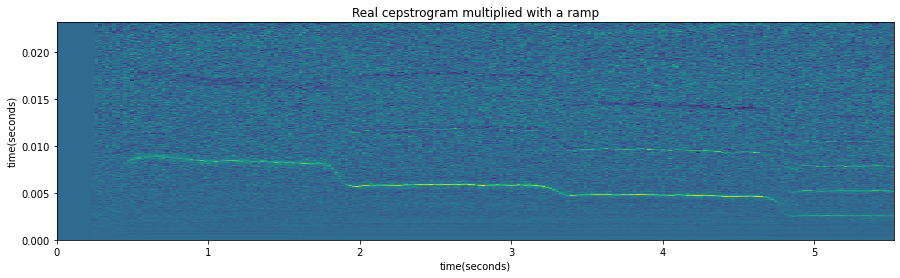

In [ ]:
def lifter_spectrogram(x_win, fftN, numCepsCoefs):

    absX = np.abs(np.fft.fft(x_win, fftN))#computing amplitude sectrogram
    absX[absX < np.finfo(float).eps] = np.finfo(float).eps#getting rid of zeros before the next step
    logSpec = np.log10(absX)
    ceps = np.real(np.fft.ifft(logSpec,fftN))#Real cepstrum
    filterCeps = np.copy(ceps)
    filterCeps[numCepsCoefs:-numCepsCoefs] = 0#suppressing excitation components
    filterSpec = np.real(np.fft.fft(filterCeps,fftN))
    sourceCeps = np.copy(ceps)
    sourceCeps[:numCepsCoefs] = 0#suppressing filter components
    sourceCeps[-numCepsCoefs:] = 0#suppressing filter components
    sourceSpec = np.real(np.fft.fft(sourceCeps,fftN))
    half_fft_n = fftN // 2
    return (ceps[:half_fft_n], logSpec[:half_fft_n], filterSpec[:half_fft_n],sourceSpec[:half_fft_n])
#------------------------

#Initialize parameters
windowSize = 2048
hopSize = windowSize / 2
windowFunction = 'blackman'
fftN = 2048
numCepsCoefs = 50
#Create the window function
w = create_window(windowSize, name=windowFunction)

#Compute required parameters for windowing
startIndexes = np.arange(0, speech_sig.size-windowSize, hopSize, dtype = int)
numWindows = startIndexes.size

spect = []
cepst = []
spect_filtOnly = []
spect_sourceOnly = []
for k in range(numWindows):
    startInd = startIndexes[k]
    x_win = speech_sig[startInd:startInd + windowSize] * w
    ceps,logSpec,filterSpec,sourceSpec = lifter_spectrogram(x_win, fftN, numCepsCoefs)
    spect.append(logSpec)
    cepst.append(ceps)
    spect_filtOnly.append(filterSpec)
    spect_sourceOnly.append(sourceSpec)
    
spect = np.array(spect)
cepst = np.array(cepst)
spect_filtOnly = np.array(spect_filtOnly)
spect_sourceOnly = np.array(spect_sourceOnly)

#Cepstrum for period/pitch detection
# Here we will simply plot cepstrum after re-shaping by multiplying with a ramp
# We expect to see a trace of fundamental period on the plot
ramp = np.arange(0,1,1 / cepst.shape[1])
for k in range(cepst.shape[0]):
    cepst[k,:] = cepst[k,:] * ramp

timeAxSec = np.arange(spect.shape[0]) * hopSize / float(fs)
timeAxSec_y = np.arange(cepst.shape[1]) / float(fs)
fig = plt.figure(figsize=(15,4))
plt.pcolormesh(timeAxSec, timeAxSec_y, np.transpose(cepst))
plt.title('Real cepstrogram multiplied with a ramp')
plt.ylabel('time(seconds)')
plt.xlabel('time(seconds)')
plt.show()

# Spectral Features on kenan_sing_o

In [ ]:
# Centriod
# URL https://www.audiocontentanalysis.org/code/audio-features/spectral-centroid-2/

X=x3
f_s=fs
def FeatureSpectralCentroid(X, f_s):

    isSpectrum = X.ndim == 1

    # X = X**2 removed for consistency with book

    norm = X.sum(axis=0, keepdims=True)
    norm[norm == 0] = 1

    vsc = np.dot(np.arange(0, X.shape[0]), X) / norm

    # convert from index to Hz
    vsc = vsc / (X.shape[0] - 1) * f_s / 2

    # if input is a spectrum, output scaler else if spectrogram, output 1d array
    vsc = np.squeeze(vsc) if isSpectrum else np.squeeze(vsc, axis=0)

    return vsc

In [ ]:
# Flux
# URL: https://www.audiocontentanalysis.org/code/audio-features/spectral-flux-2/

def FeatureSpectralFlux(X, f_s):

    isSpectrum = X.ndim == 1
    if isSpectrum:
        X = np.expand_dims(X, axis=1)

    # difference spectrum (set first diff to zero)
    X = np.c_[X[:, 0], X]

    afDeltaX = np.diff(X, 1, axis=1)

    # flux
    vsf = np.sqrt((afDeltaX**2).sum(axis=0)) / X.shape[0]

    return np.squeeze(vsf) if isSpectrum else vsf

In [ ]:
# Slpoe
# URL: https://www.audiocontentanalysis.org/code/audio-features/spectral-slope-2/

def FeatureSpectralSlope(X, f_s):

    # compute mean
    mu_x = X.mean(axis=0, keepdims=True)

    # compute index vector
    kmu = np.arange(0, X.shape[0]) - X.shape[0] / 2

    # compute slope
    X = X - mu_x
    vssl = np.dot(kmu, X) / np.dot(kmu, kmu)

    return vssl

# Windowing on kenan_sing_a

In [ ]:
speech_sig=x1 # Allowing speech_sig to take the value of the sound 'a'

# parameters
windowSize = 0.03*fs # The window length is 30 milliseconds
hopSize = 0.015*fs # The Hop/Shift size is 15 milliseconds
NRG_threshold_ratio = 0.05 #threshold expressed as ratio with respect to the maximum value (5%)
#Let's put in a container to be able to use as a single argument in function calls
params = {"fs":fs, "windowSize":windowSize, "hopSize":hopSize, "NRG_threshold_ratio": NRG_threshold_ratio}
#Function definition
def split_file(filename, params):
    '''Function to define split boundaries based on a fixed energy threshold
    '''
    x = ess.MonoLoader(filename = x1, sampleRate = fs)()
    NRG = [];
    #Main windowing and feature extraction loop
    for frame in ess.FrameGenerator(x, frameSize = windowSize, hopSize = hopSize, startFromZero = True):
        NRG.append(ess.Energy()(frame))
    NRG = np.array(NRG)
    NRG = NRG / np.max(NRG)
    
    #Applying energy threshold to decide wave split boundaries
    split_decision_func = np.zeros_like(NRG)
    split_decision_func[NRG > NRG_threshold_ratio] = 1
    #Setting segment boundaries
    #Inserting a zero at the beginning since we will decide the transitions using a diff function
    split_decision_func = np.insert(split_decision_func, 0, 0)
    diff_split_decision = np.diff(split_decision_func)
    #Start indexes: transition from 0 to 1
    start_indexes = np.nonzero(diff_split_decision > 0)[0] * hopSize
    #Stop indexes: transition from 1 to 0
    stop_indexes = np.nonzero(diff_split_decision < 0)[0] * hopSize
    return (x, NRG, split_decision_func, start_indexes, stop_indexes) 

# Producing Formant Speace via Formant Values of Frames on kenen_sing_a.

Number of polynomial coeffecients was set to 40 and Number of formants was set to 10. 

r =  0.9941961 , freq =  429.58746 Hz
r =  0.9879279 , freq =  847.7788 Hz
r =  0.9856693 , freq =  4310.548 Hz
r =  0.9841639 , freq =  7284.8784 Hz
r =  0.97643685 , freq =  9020.924 Hz
r =  0.9725178 , freq =  2711.8105 Hz
r =  0.9672646 , freq =  22050.0 Hz
r =  0.95805717 , freq =  5871.8467 Hz
r =  0.942584 , freq =  10399.33 Hz
r =  0.9398565 , freq =  20838.873 Hz
Spectrum plots shifted and scaled for better viewing of the seperate components


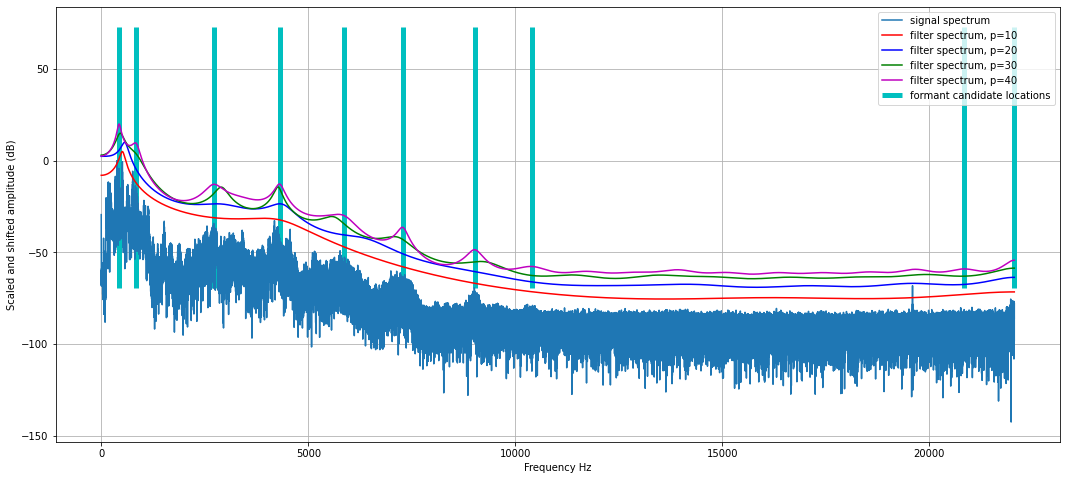

In [ ]:
speech_sig = x1
def lpc_spectrum(speech_sig, num_coefs, num_freq_point):
  a = librosa.lpc(speech_sig, num_coefs)
  w, h = freqz(1, a, num_freq_points)
  return w, 20 * np.log10(np.abs(h))

def estimate_formants_lpc(speech_sig, fs, num_coefs=40, num_formants=10):
  a = librosa.lpc(speech_sig, num_coefs)
  roots = np.roots(a)
  roots_r = np.abs(roots)
  roots_theta = np.angle(roots)
  #drop roots at negative frequencies
  positive_freq_indexes = roots_theta > 0
  roots_r = roots_r[positive_freq_indexes]
  roots_theta = roots_theta[positive_freq_indexes]
  #sort roots with respect to their norm
  sort_indexes = np.flip(np.argsort(roots_r))
  roots_r = roots_r[sort_indexes]
  roots_theta = roots_theta[sort_indexes]

  return roots_r[:num_formants], roots_theta[:num_formants] * fs / (2 * np.pi)

num_formants = 10
roots_r, formant_candidate_freqs = estimate_formants_lpc(windowed_sig, fs, 40, num_formants)
for root_r, formant_freq in zip(roots_r, formant_candidate_freqs):
  print('r = ', root_r, ', freq = ', formant_freq, 'Hz')

fft_n = pow(2,int(np.log2(windowed_sig.size) + 1))
amp_spec = 20 * np.log10(np.abs(np.fft.fft(windowed_sig,n=fft_n)[:fft_n//2]))

print("Spectrum plots shifted and scaled for better viewing of the seperate components")
plt.figure(figsize=(18,8))
num_freq_points = amp_spec.size
w, filter_10_spec = lpc_spectrum(windowed_sig, 10, num_freq_points)
freq_axis = w * fs / (2*np.pi)
plt.plot(freq_axis, amp_spec-np.max(amp_spec), label='signal spectrum');
plt.plot(freq_axis, filter_10_spec - np.max(filter_10_spec) + 5, 'r', label='filter spectrum, p=10');
w, filter_20_spec = lpc_spectrum(windowed_sig, 20, num_freq_points)
plt.plot(freq_axis, filter_20_spec - np.max(filter_20_spec) + 10, 'b', label='filter spectrum, p=20');
w, filter_30_spec = lpc_spectrum(windowed_sig, 30, num_freq_points)
plt.plot(freq_axis, filter_30_spec - np.max(filter_30_spec) + 15, 'g', label='filter spectrum, p=30');
w, filter_40_spec = lpc_spectrum(windowed_sig, 40, num_freq_points)
plt.plot(freq_axis, filter_40_spec - np.max(filter_40_spec) + 20, 'm', label='filter spectrum, p=40');
plt.vlines(formant_candidate_freqs,np.min(amp_spec), np.max(amp_spec), 'c', linewidth = 5, label = 'formant candidate locations')
plt.legend();
plt.xlabel("Frequency Hz");
plt.ylabel("Scaled and shifted amplitude (dB)");
plt.grid();

# Crepe Function

In [ ]:
import crepe 
import copy
# Performing Crepe on kenan_sing_a
time, frequency, confidence, activation = crepe.predict(speech_sig, sr = fs, viterbi=True)
periods = 1 / frequency#periods in seconds

21/21 [==============================] - 36s 2s/step


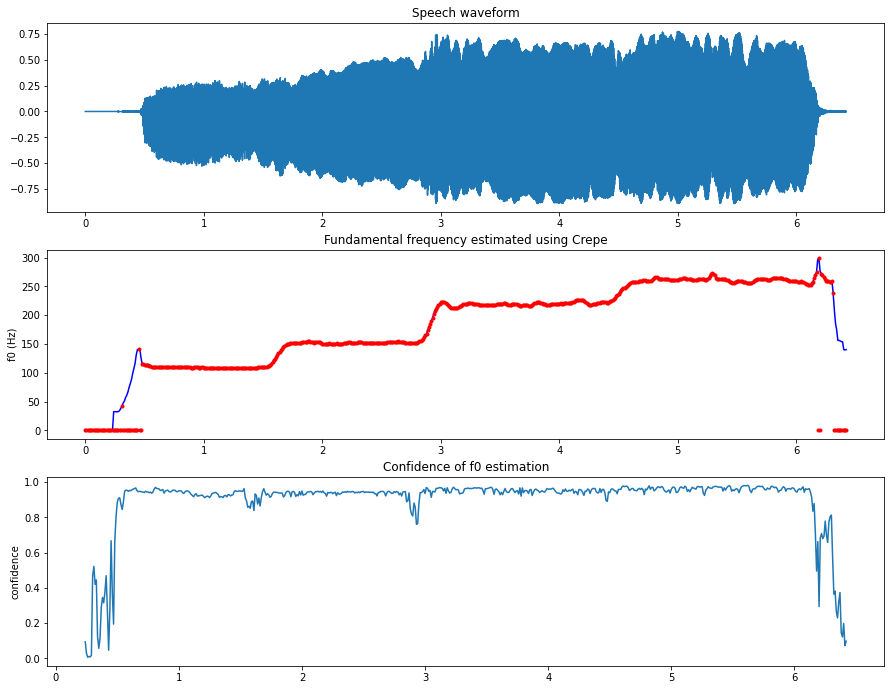

In [ ]:
# Plotting the fundemantal frequency estimation using crepe along with confedence of the estimation for kenan_sing_a (When confedence is less than 0.5, it is equalized to zero)
fig = plt.figure(figsize=(15,16))
t_xax = np.arange(0,speech_sig.size/fs,1/fs)
plt.subplot(4,1,1)
plt.plot(t_xax, speech_sig)
plt.title('Speech waveform')
plt.subplot(4,1,2)
plt.plot(time, frequency,'b', label = 'crepe - all f0')
frequency_filtered = copy.deepcopy(frequency)
frequency_filtered[confidence < 0.5] = 0
plt.plot(time, frequency_filtered,'r.', label = 'crepe - high confidence f0')
plt.title('Fundamental frequency estimated using Crepe')
plt.ylabel('f0 (Hz)')
plt.subplot(4,1,3)
plt.plot(time, confidence)
plt.title('Confidence of f0 estimation')
plt.ylabel('confidence');

# Converting fundemantal frequencies to midi numbers on kenan_sing_a

MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  32.414550681103606  Hz =  23
MIDI# of  32.416668226809875  Hz =  23
MIDI# of  32.198560442954246  Hz =  23
MIDI# of  32.250231413237785  Hz =  23
MIDI# of  32.60917603445468  Hz =  23
MIDI# of  34.429827878358545  Hz =  24
MIDI# of  38.26160253477334  Hz =  26
MIDI# of  41.61423575225378  Hz =  28
MIDI# of  47.51445676926978  Hz =  30
MIDI# of  50.55683518261341  Hz =  31
MIDI# of  56.87647968239577  Hz =  33
MIDI# of  60.791044629695

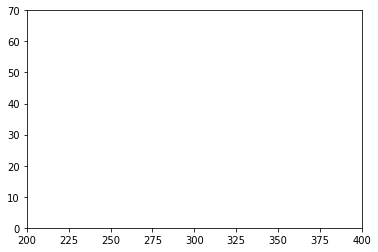

In [ ]:
def hz_to_midi(frequency_hz):
  if frequency_hz <= 0:
    return 0
  else:
     return 69 + np.log2(frequency_hz/440) * 12

frequencies = frequency
for freq_hz in frequencies:
  print('MIDI# of ',freq_hz, ' Hz = ', int(hz_to_midi(freq_hz)))

plt.xlim(200, 400)
plt.ylim(0,70)
plt.plot(freq_hz, int(hz_to_midi(freq_hz)))

# Plotting chromagram on kenan_sing_a

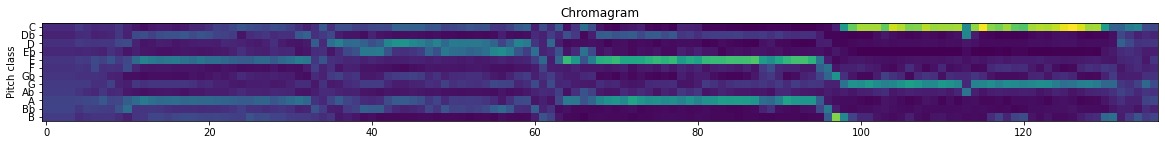

In [ ]:
def log_magnitude_spectrum(speech_sig, fftN):

  X = np.fft.fft(speech_sig, fftN)#computing fft
  absX = np.abs(X[:int(fftN / 2)])#taking first half of the spectrum and its magnitude
  absX[absX < np.finfo(float).eps] = np.finfo(float).eps#getting rid of zeros before the next step
  mX = 20 * np.log10(absX)
  return mX

def plot_chroma(speech_sig, windowFunction, windowSize, hopSize, fftN, min_freq, max_freq, fs):
  
  min_freq_bin = round(min_freq * fftN / fs)
  max_freq_bin = round(max_freq * fftN / fs)

  #Create the window function
  w = get_window(windowFunction, windowSize)

  #Required parameters for windowing
  startIndexes = np.arange(0, speech_sig.size - windowSize, hopSize, dtype = int)
  numWindows = startIndexes.size

  # Performing windowing and using the logMagnitudeSpectrum function to compute the spectrum for each frame
  chroma = []
  for k in range(numWindows):
      startInd = startIndexes[k]
      x_win = speech_sig[startInd:startInd + windowSize] * w
      linear_spec = np.power(10, log_magnitude_spectrum(x_win, fftN) /20 )#better view with linear amplitude values
      bandEnergies = np.zeros((12,))
      for freqBin in np.arange(min_freq_bin,max_freq_bin):

          freqBinHz = freqBin * fs / fftN
          binMidi = int(np.round(hz_to_midi(freqBinHz)))
          bandEnergies[np.mod(binMidi,12)] += linear_spec[freqBin]
          
      bandEnergies = bandEnergies / np.sum(bandEnergies)
      chroma.append(bandEnergies)
  chroma = np.array(chroma) 

  pitchClasses = ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab','A', 'Bb', 'B']

  fig = plt.figure(figsize = (20, 8))
  plt.imshow(chroma.transpose()) 
  plt.title('Chromagram')
  plt.yticks(np.arange(12), pitchClasses)
  plt.ylabel('Pitch class')
  return chroma

  #Initialize parameters
windowSize = 4096
hopSize = 2048
fftN = 4096
min_freq = 100
max_freq = 4000

plot_chroma(speech_sig, 'hann', windowSize, hopSize, fftN, min_freq, max_freq, fs);

# Comments on fundemantal frequencies, Midi numbers and chromagram for kenan_sing_a

With increasing pitch of chromatic scale, the chroma values cycliclly rip around the virtical chroma axis.
The intensity of the sound is relatively low (blue colored in chromagram) with increasing of intensity over the peiod of the sound (seen in green). That also can be noticed through MIDI increasing values of integers and increasing of fundemantal frequencies.

# Implementing Cepstrum based fundemantal frequency detector

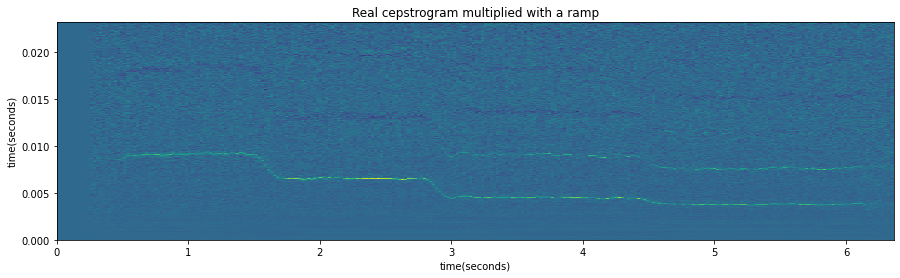

In [ ]:

def lifter_spectrogram(x_win, fftN, numCepsCoefs):

    absX = np.abs(np.fft.fft(x_win, fftN))#computing amplitude sectrogram
    absX[absX < np.finfo(float).eps] = np.finfo(float).eps#getting rid of zeros before the next step
    logSpec = np.log10(absX)
    ceps = np.real(np.fft.ifft(logSpec,fftN))#Real cepstrum
    filterCeps = np.copy(ceps)
    filterCeps[numCepsCoefs:-numCepsCoefs] = 0#suppressing excitation components
    filterSpec = np.real(np.fft.fft(filterCeps,fftN))
    sourceCeps = np.copy(ceps)
    sourceCeps[:numCepsCoefs] = 0#suppressing filter components
    sourceCeps[-numCepsCoefs:] = 0#suppressing filter components
    sourceSpec = np.real(np.fft.fft(sourceCeps,fftN))
    half_fft_n = fftN // 2
    return (ceps[:half_fft_n], logSpec[:half_fft_n], filterSpec[:half_fft_n],sourceSpec[:half_fft_n])
#------------------------

#Initialize parameters
windowSize = 2048
hopSize = windowSize / 2
windowFunction = 'blackman'
fftN = 2048
numCepsCoefs = 50
#Create the window function
w = create_window(windowSize, name=windowFunction)

#Compute required parameters for windowing
startIndexes = np.arange(0, speech_sig.size-windowSize, hopSize, dtype = int)
numWindows = startIndexes.size

spect = []
cepst = []
spect_filtOnly = []
spect_sourceOnly = []
for k in range(numWindows):
    startInd = startIndexes[k]
    x_win = speech_sig[startInd:startInd + windowSize] * w
    ceps,logSpec,filterSpec,sourceSpec = lifter_spectrogram(x_win, fftN, numCepsCoefs)
    spect.append(logSpec)
    cepst.append(ceps)
    spect_filtOnly.append(filterSpec)
    spect_sourceOnly.append(sourceSpec)
    
spect = np.array(spect)
cepst = np.array(cepst)
spect_filtOnly = np.array(spect_filtOnly)
spect_sourceOnly = np.array(spect_sourceOnly)

#Cepstrum for period/pitch detection
# Here we will simply plot cepstrum after re-shaping by multiplying with a ramp
# We expect to see a trace of fundamental period on the plot
ramp = np.arange(0,1,1 / cepst.shape[1])
for k in range(cepst.shape[0]):
    cepst[k,:] = cepst[k,:] * ramp

timeAxSec = np.arange(spect.shape[0]) * hopSize / float(fs)
timeAxSec_y = np.arange(cepst.shape[1]) / float(fs)
fig = plt.figure(figsize=(15,4))
plt.pcolormesh(timeAxSec, timeAxSec_y, np.transpose(cepst))
plt.title('Real cepstrogram multiplied with a ramp')
plt.ylabel('time(seconds)')
plt.xlabel('time(seconds)')
plt.show()

# Spectral features on kenan_sing_a

In [ ]:
# Spectral Centriod
# URL https://www.audiocontentanalysis.org/code/audio-features/spectral-centroid-2/

f_s=fs
X=x1
def FeatureSpectralCentroid(X, f_s):

    isSpectrum = X.ndim == 1

    # X = X**2 removed for consistency with book

    norm = X.sum(axis=0, keepdims=True)
    norm[norm == 0] = 1

    vsc = np.dot(np.arange(0, X.shape[0]), X) / norm

    # convert from index to Hz
    vsc = vsc / (X.shape[0] - 1) * f_s / 2

    # if input is a spectrum, output scaler else if spectrogram, output 1d array
    vsc = np.squeeze(vsc) if isSpectrum else np.squeeze(vsc, axis=0)

    return vsc

In [ ]:
# Flux
# URL: https://www.audiocontentanalysis.org/code/audio-features/spectral-flux-2/

def FeatureSpectralFlux(X, f_s):

    isSpectrum = X.ndim == 1
    if isSpectrum:
        X = np.expand_dims(X, axis=1)

    # difference spectrum (set first diff to zero)
    X = np.c_[X[:, 0], X]

    afDeltaX = np.diff(X, 1, axis=1)

    # flux
    vsf = np.sqrt((afDeltaX**2).sum(axis=0)) / X.shape[0]

    return np.squeeze(vsf) if isSpectrum else vsf

In [ ]:
# Slpoe
# URL: https://www.audiocontentanalysis.org/code/audio-features/spectral-slope-2/

def FeatureSpectralSlope(X, f_s):

    # compute mean
    mu_x = X.mean(axis=0, keepdims=True)

    # compute index vector
    kmu = np.arange(0, X.shape[0]) - X.shape[0] / 2

    # compute slope
    X = X - mu_x
    vssl = np.dot(kmu, X) / np.dot(kmu, kmu)

    return vssl

# Windowing on kenan_sing_e

In [ ]:
speech_sig=x2 # Allowing speech_sig to take the value of the sound 'e'

# parameters
windowSize = 0.03*fs # The window length is 30 milliseconds
hopSize = 0.015*fs # The Hop/Shift size is 15 milliseconds
NRG_threshold_ratio = 0.05 #threshold expressed as ratio with respect to the maximum value (5%)
#Let's put in a container to be able to use as a single argument in function calls
params = {"fs":fs, "windowSize":windowSize, "hopSize":hopSize, "NRG_threshold_ratio": NRG_threshold_ratio}
#Function definition
def split_file(filename, params):
    '''Function to define split boundaries based on a fixed energy threshold
    '''
    x = ess.MonoLoader(filename = x2, sampleRate = fs)()
    NRG = [];
    #Main windowing and feature extraction loop
    for frame in ess.FrameGenerator(x, frameSize = windowSize, hopSize = hopSize, startFromZero = True):
        NRG.append(ess.Energy()(frame))
    NRG = np.array(NRG)
    NRG = NRG / np.max(NRG)
    
    #Applying energy threshold to decide wave split boundaries
    split_decision_func = np.zeros_like(NRG)
    split_decision_func[NRG > NRG_threshold_ratio] = 1
    #Setting segment boundaries
    #Inserting a zero at the beginning since we will decide the transitions using a diff function
    split_decision_func = np.insert(split_decision_func, 0, 0)
    diff_split_decision = np.diff(split_decision_func)
    #Start indexes: transition from 0 to 1
    start_indexes = np.nonzero(diff_split_decision > 0)[0] * hopSize
    #Stop indexes: transition from 1 to 0
    stop_indexes = np.nonzero(diff_split_decision < 0)[0] * hopSize
    return (x, NRG, split_decision_func, start_indexes, stop_indexes) 

# Producing formants on kenan_sing_e

Number of polynomial coeffecients was set to 40 and Number of formants was set to 10. 

r =  0.9941961 , freq =  429.58746 Hz
r =  0.9879279 , freq =  847.7788 Hz
r =  0.9856693 , freq =  4310.548 Hz
r =  0.9841639 , freq =  7284.8784 Hz
r =  0.97643685 , freq =  9020.924 Hz
r =  0.9725178 , freq =  2711.8105 Hz
r =  0.9672646 , freq =  22050.0 Hz
r =  0.95805717 , freq =  5871.8467 Hz
r =  0.942584 , freq =  10399.33 Hz
r =  0.9398565 , freq =  20838.873 Hz
Spectrum plots shifted and scaled for better viewing of the seperate components


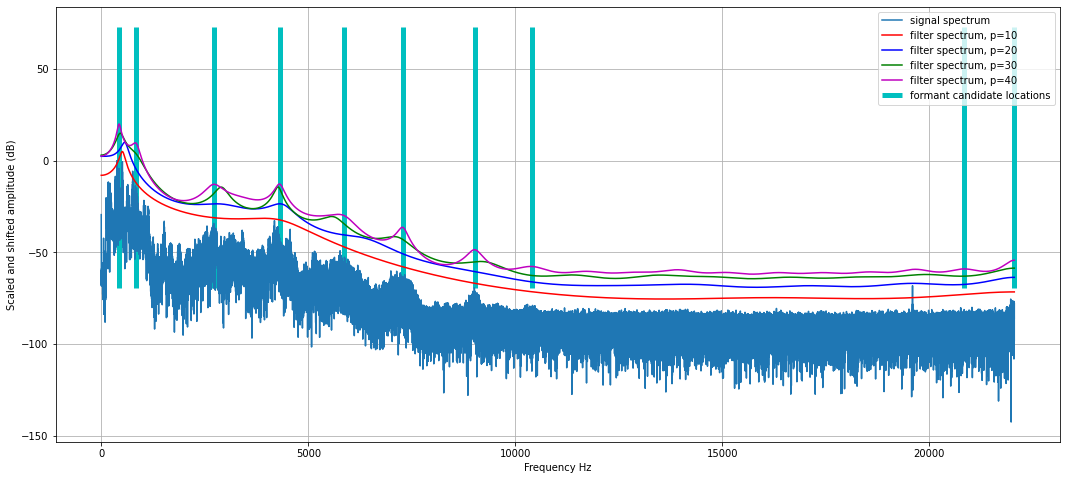

In [ ]:
speech_sig=x1
def lpc_spectrum(speech_sig, num_coefs, num_freq_point):
  a = librosa.lpc(speech_sig, num_coefs)
  w, h = freqz(1, a, num_freq_points)
  return w, 20 * np.log10(np.abs(h))

def estimate_formants_lpc(speech_sig, fs, num_coefs=40, num_formants=10):
  a = librosa.lpc(speech_sig, num_coefs)
  roots = np.roots(a)
  roots_r = np.abs(roots)
  roots_theta = np.angle(roots)
  #drop roots at negative frequencies
  positive_freq_indexes = roots_theta > 0
  roots_r = roots_r[positive_freq_indexes]
  roots_theta = roots_theta[positive_freq_indexes]
  #sort roots with respect to their norm
  sort_indexes = np.flip(np.argsort(roots_r))
  roots_r = roots_r[sort_indexes]
  roots_theta = roots_theta[sort_indexes]

  return roots_r[:num_formants], roots_theta[:num_formants] * fs / (2 * np.pi)

num_formants = 10
roots_r, formant_candidate_freqs = estimate_formants_lpc(windowed_sig, fs, 40, num_formants)
for root_r, formant_freq in zip(roots_r, formant_candidate_freqs):
  print('r = ', root_r, ', freq = ', formant_freq, 'Hz')

fft_n = pow(2,int(np.log2(windowed_sig.size) + 1))
amp_spec = 20 * np.log10(np.abs(np.fft.fft(windowed_sig,n=fft_n)[:fft_n//2]))

print("Spectrum plots shifted and scaled for better viewing of the seperate components")
plt.figure(figsize=(18,8))
num_freq_points = amp_spec.size
w, filter_10_spec = lpc_spectrum(windowed_sig, 10, num_freq_points)
freq_axis = w * fs / (2*np.pi)
plt.plot(freq_axis, amp_spec-np.max(amp_spec), label='signal spectrum');
plt.plot(freq_axis, filter_10_spec - np.max(filter_10_spec) + 5, 'r', label='filter spectrum, p=10');
w, filter_20_spec = lpc_spectrum(windowed_sig, 20, num_freq_points)
plt.plot(freq_axis, filter_20_spec - np.max(filter_20_spec) + 10, 'b', label='filter spectrum, p=20');
w, filter_30_spec = lpc_spectrum(windowed_sig, 30, num_freq_points)
plt.plot(freq_axis, filter_30_spec - np.max(filter_30_spec) + 15, 'g', label='filter spectrum, p=30');
w, filter_40_spec = lpc_spectrum(windowed_sig, 40, num_freq_points)
plt.plot(freq_axis, filter_40_spec - np.max(filter_40_spec) + 20, 'm', label='filter spectrum, p=40');
plt.vlines(formant_candidate_freqs,np.min(amp_spec), np.max(amp_spec), 'c', linewidth = 5, label = 'formant candidate locations')
plt.legend();
plt.xlabel("Frequency Hz");
plt.ylabel("Scaled and shifted amplitude (dB)");
plt.grid();

# Crepe Function

In [ ]:
# Performing Crepe on kenan_sing_a
time, frequency, confidence, activation = crepe.predict(speech_sig, sr = fs, viterbi=True)
periods = 1 / frequency #periods in seconds

21/21 [==============================] - 32s 2s/step


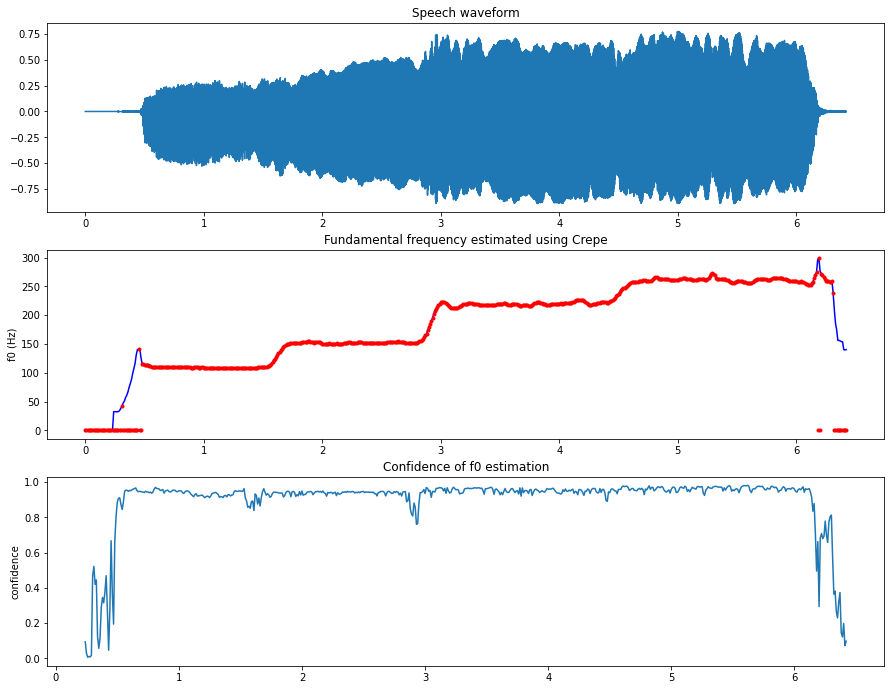

In [ ]:
# Plotting the fundemantal frequency estimation using crepe along with confedence of the estimation for kenan_sing_e (When confedence is less than 0.5, it is equalized to zero)

fig = plt.figure(figsize=(15,16))
t_xax = np.arange(0,speech_sig.size/fs,1/fs)
plt.subplot(4,1,1)
plt.plot(t_xax, speech_sig)
plt.title('Speech waveform')
plt.subplot(4,1,2)
plt.plot(time, frequency,'b', label = 'crepe - all f0')
frequency_filtered = copy.deepcopy(frequency)
frequency_filtered[confidence < 0.5] = 0
plt.plot(time, frequency_filtered,'r.', label = 'crepe - high confidence f0')
plt.title('Fundamental frequency estimated using Crepe')
plt.ylabel('f0 (Hz)')
plt.subplot(4,1,3)
plt.plot(time, confidence)
plt.title('Confidence of f0 estimation')
plt.ylabel('confidence');

# Converting fundemantal frequencies to midi numbers on kenan_sing_e

MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  0.0  Hz =  0
MIDI# of  32.414550681103606  Hz =  23
MIDI# of  32.416668226809875  Hz =  23
MIDI# of  32.198560442954246  Hz =  23
MIDI# of  32.250231413237785  Hz =  23
MIDI# of  32.60917603445468  Hz =  23
MIDI# of  34.429827878358545  Hz =  24
MIDI# of  38.26160253477334  Hz =  26
MIDI# of  41.61423575225378  Hz =  28
MIDI# of  47.51445676926978  Hz =  30
MIDI# of  50.55683518261341  Hz =  31
MIDI# of  56.87647968239577  Hz =  33
MIDI# of  60.791044629695

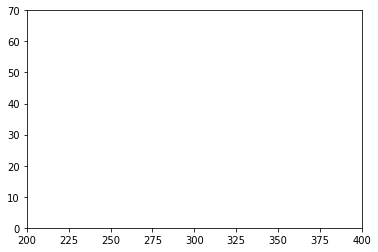

In [ ]:
def hz_to_midi(frequency_hz):
  if frequency_hz <= 0:
    return 0
  else:
     return 69 + np.log2(frequency_hz/440) * 12

frequencies = frequency
for freq_hz in frequencies:
  print('MIDI# of ',freq_hz, ' Hz = ', int(hz_to_midi(freq_hz)))

plt.xlim(200, 400)
plt.ylim(0,70)
plt.plot(freq_hz, int(hz_to_midi(freq_hz)))

In [ ]:
def log_magnitude_spectrum(x, fftN):

  X = np.fft.fft(x, fftN)#computing fft
  absX = np.abs(X[:int(fftN / 2)])#taking first half of the spectrum and its magnitude
  absX[absX < np.finfo(float).eps] = np.finfo(float).eps#getting rid of zeros before the next step
  mX = 20 * np.log10(absX)
  return mX

def plot_chroma(x, windowFunction, windowSize, hopSize, fftN, min_freq, max_freq, fs):
  
  min_freq_bin = round(min_freq * fftN / fs)
  max_freq_bin = round(max_freq * fftN / fs)

  #Create the window function
  w = get_window(windowFunction, windowSize)

  #Required parameters for windowing
  startIndexes = np.arange(0, x.size - windowSize, hopSize, dtype = int)
  numWindows = startIndexes.size

  #Write the code to compute spectrogram (mX) in the form of a matrix
  # Performing windowing and using the logMagnitudeSpectrum function to compute the spectrum for each frame
  chroma = []
  for k in range(numWindows):
      startInd = startIndexes[k]
      x_win = x[startInd:startInd + windowSize] * w
      linear_spec = np.power(10, log_magnitude_spectrum(x_win, fftN) /20 )#better view with linear amplitude values
      bandEnergies = np.zeros((12,))
      for freqBin in np.arange(min_freq_bin,max_freq_bin):
          #Your code starts here
          # Write the code that maps freqBin to an integer midiNumber and adds
          # the amplitude of the spectrum at that bin at the 
          # corresponding component of 'bandEnergies' array
          freqBinHz = freqBin * fs / fftN
          binMidi = int(np.round(hz_to_midi(freqBinHz)))
          bandEnergies[np.mod(binMidi,12)] += linear_spec[freqBin]
          #Your code ends here
      bandEnergies = bandEnergies / np.sum(bandEnergies)
      chroma.append(bandEnergies)
  chroma = np.array(chroma) 

  pitchClasses = ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab','A', 'Bb', 'B']

  fig = plt.figure(figsize = (20, 8))
  plt.imshow(chroma.transpose())
  #ax.tick_params(axis = 'x',which = 'both',top = 'off',bottom = 'off',labelbottom = 'off') 
  plt.title('Chromagram')
  plt.yticks(np.arange(12), pitchClasses)
  plt.ylabel('Pitch class')
  return chroma

  #Initialize parameters
windowSize = 4096
hopSize = 2048
fftN = 4096
min_freq = 100
max_freq = 4000

plot_chroma(x, 'hann', windowSize, hopSize, fftN, min_freq, max_freq, fs);

NameError: ignored

# Plotting chromagram for kenen_sing_e

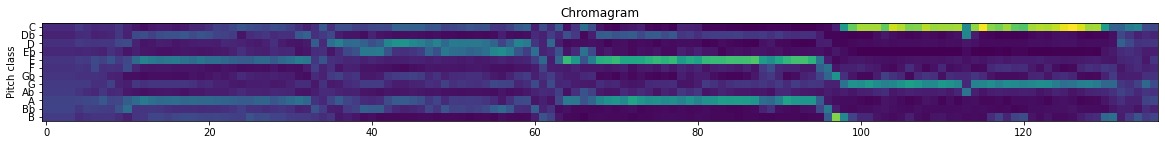

In [ ]:
def log_magnitude_spectrum(speech_sig, fftN):

  X = np.fft.fft(speech_sig, fftN)#computing fft
  absX = np.abs(X[:int(fftN / 2)])#taking first half of the spectrum and its magnitude
  absX[absX < np.finfo(float).eps] = np.finfo(float).eps#getting rid of zeros before the next step
  mX = 20 * np.log10(absX)
  return mX

def plot_chroma(speech_sig, windowFunction, windowSize, hopSize, fftN, min_freq, max_freq, fs):
  
  min_freq_bin = round(min_freq * fftN / fs)
  max_freq_bin = round(max_freq * fftN / fs)

  #Create the window function
  w = get_window(windowFunction, windowSize)

  #Required parameters for windowing
  startIndexes = np.arange(0, speech_sig.size - windowSize, hopSize, dtype = int)
  numWindows = startIndexes.size

  # Performing windowing and using the logMagnitudeSpectrum function to compute the spectrum for each frame
  chroma = []
  for k in range(numWindows):
      startInd = startIndexes[k]
      x_win = speech_sig[startInd:startInd + windowSize] * w
      linear_spec = np.power(10, log_magnitude_spectrum(x_win, fftN) /20 )#better view with linear amplitude values
      bandEnergies = np.zeros((12,))
      for freqBin in np.arange(min_freq_bin,max_freq_bin):

          freqBinHz = freqBin * fs / fftN
          binMidi = int(np.round(hz_to_midi(freqBinHz)))
          bandEnergies[np.mod(binMidi,12)] += linear_spec[freqBin]
          
      bandEnergies = bandEnergies / np.sum(bandEnergies)
      chroma.append(bandEnergies)
  chroma = np.array(chroma) 

  pitchClasses = ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab','A', 'Bb', 'B']

  fig = plt.figure(figsize = (20, 8))
  plt.imshow(chroma.transpose()) 
  plt.title('Chromagram')
  plt.yticks(np.arange(12), pitchClasses)
  plt.ylabel('Pitch class')
  return chroma

  #Initialize parameters
windowSize = 4096
hopSize = 2048
fftN = 4096
min_freq = 100
max_freq = 4000

plot_chroma(speech_sig, 'hann', windowSize, hopSize, fftN, min_freq, max_freq, fs);

# Comments on fundemantal frequencies, Midi numbers, and chromagram

With increasing pitch of chromatic scale, the chroma values cycliclly rip around the virtical chroma axis.
The intensity of the sound is relatively low (blue colored in chromagram) with increasing of intensity over the peiod of the sound (seen in green). That also can be noticed through MIDI increasing values of integers and increasing of fundemantal frequencies.

# Implementing Cepstrum based fundemantal frequency detecter

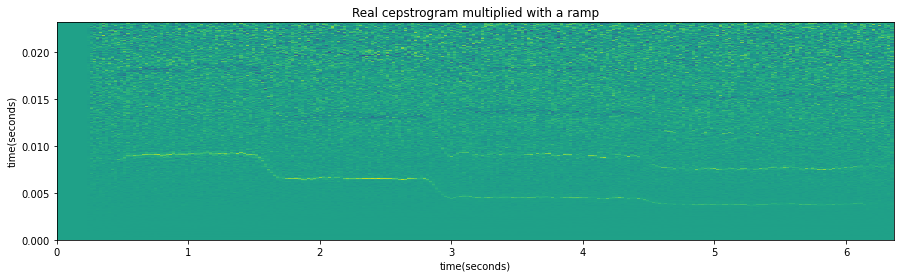

In [ ]:
#Cepstrum for period/pitch detection
# Here we will simply plot cepstrum after re-shaping by multiplying with a ramp
# We expect to see a trace of fundamental period on the plot
ramp = np.arange(0,1,1 / cepst.shape[1])
for k in range(cepst.shape[0]):
    cepst[k,:] = cepst[k,:] * ramp

timeAxSec_y = np.arange(cepst.shape[1]) / float(fs)
fig = plt.figure(figsize=(15,4))
plt.pcolormesh(timeAxSec, timeAxSec_y, np.transpose(cepst))
plt.title('Real cepstrogram multiplied with a ramp')
plt.ylabel('time(seconds)')
plt.xlabel('time(seconds)')
plt.show()

# Spectral features on kenan_sing_e

In [ ]:
# Spectral Centriod
# URL https://www.audiocontentanalysis.org/code/audio-features/spectral-centroid-2/

f_s=fs
X=x2
def FeatureSpectralCentroid(X, f_s):

    isSpectrum = X.ndim == 1

    # X = X**2 removed for consistency with book

    norm = X.sum(axis=0, keepdims=True)
    norm[norm == 0] = 1

    vsc = np.dot(np.arange(0, X.shape[0]), X) / norm

    # convert from index to Hz
    vsc = vsc / (X.shape[0] - 1) * f_s / 2

    # if input is a spectrum, output scaler else if spectrogram, output 1d array
    vsc = np.squeeze(vsc) if isSpectrum else np.squeeze(vsc, axis=0)

    return vsc

In [ ]:
# Flux
# URL: https://www.audiocontentanalysis.org/code/audio-features/spectral-flux-2/

def FeatureSpectralFlux(X, f_s):

    isSpectrum = X.ndim == 1
    if isSpectrum:
        X = np.expand_dims(X, axis=1)

    # difference spectrum (set first diff to zero)
    X = np.c_[X[:, 0], X]

    afDeltaX = np.diff(X, 1, axis=1)

    # flux
    vsf = np.sqrt((afDeltaX**2).sum(axis=0)) / X.shape[0]

    return np.squeeze(vsf) if isSpectrum else vsf

In [ ]:
# Slpoe
# URL: https://www.audiocontentanalysis.org/code/audio-features/spectral-slope-2/

def FeatureSpectralSlope(X, f_s):

    # compute mean
    mu_x = X.mean(axis=0, keepdims=True)

    # compute index vector
    kmu = np.arange(0, X.shape[0]) - X.shape[0] / 2

    # compute slope
    X = X - mu_x
    vssl = np.dot(kmu, X) / np.dot(kmu, kmu)

    return vssl

# Breif Explanation of the usage of discussed spectral features

URL: https://www.mathworks.com/help/audio/ug/spectral-descriptors.html

-Spectral Centriod is usually prefered in music analysis and genre classification. It is also used to classify sounds as voiced or unvoiced. For example, it can be used to observe the jumps in the centroid corresponding to high hat hits in an audio file such as the centriod jumps of the region of unvoiced speech.  
-Spectral flux is commonly used in audio segmentation. For example the beats of drum represent high flux.
-SPectral slope is commonly used in speech analysis, mainly in model the speaker stress or speaker identificationa as it is related to resonanse charecteristics of the vocal folds.
